In [2]:
import os, glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
age = pd.read_csv('phenotype/Interview_Dates_Update.csv', dtype={'SUBJID':str})
phenotype = pd.read_csv('phenotype/Subject_Phenotypes.csv', dtype={'SUBJID':str},
                        usecols=['SUBJID', 'Race', 'Sex'])

# drop proband+collateral interview duplicates
phenotype.drop_duplicates('SUBJID', inplace=True)

In [3]:
FCON_PATH = os.path.join('output', 'xcpengine', 'cohort_*', 'sub-{sub}',
                         'fcon', '{atlas}', 'sub-{sub}_{atlas}_network.txt')
ATLAS_PATH = os.path.join('atlas', '{atlas}', '{atlas}')
OUTPUT_PATH = os.path.join('output', '{atlas}')

# Within/Between Connectivity

In [4]:
class Atlas_Loader:

    def __init__(self, atlas, affiliation=None):
        files = glob.glob(FCON_PATH.format(sub='*', atlas=atlas))
        self.sub_files = {os.path.basename(f).partition('_')[0].rpartition('-')[2] : f
                          for f in files}
        
        if affiliation is None:
            affiliation = np.loadtxt(
                ATLAS_PATH.format(atlas=atlas) + 'CommunityAffiliation.1D', dtype=int
            ) - 1 # 1 to 0 indexing
        self.affiliation = affiliation
        self.n_node = affiliation.shape[0]
        self.n_comm = affiliation.max() + 1
    
    def __len__(self):
        return len(self.sub_files)
    
    def fcon_matrix(self, sub, fisher=False, cache=None):
        networktxt = np.loadtxt(self.sub_files[sub])
        fcon = np.zeros((self.n_node, self.n_node))
        
        n = 0
        for i in range(self.n_node):
            for j in range(self.n_node):
                if j < i: # symmetric
                    fcon[i][j] = fcon[j][i]
                elif j == i:
                    fcon[i][j] = 1
                else:
                    fcon[i][j] = networktxt[n]
                    n += 1
        
        if fisher:
            fcon = np.arctanh(fcon)
        if cache is not None:
            np.save(os.path.join(cache, 'fcon', 'sub-{sub}_fcon.npy').format(sub=sub), fcon)
        
        return fcon
    
    def ccon_matrix(self, fcon):
        ccon = np.zeros((self.n_comm, self.n_comm))

        for i in range(self.n_comm):
            for j in range(self.n_comm):
                if j < i: # symmetric
                    ccon[i][j] = ccon[j][i]
                    continue
                fcon_ij = fcon[self.affiliation == i, :][:, self.affiliation == j]
                if j == i:
                    ccon[i][j] = np.nanmean(fcon_ij[np.triu_indices_from(fcon_ij, k=1)])
                else:
                    ccon[i][j] = np.nanmean(fcon_ij)
        
        return ccon

In [5]:
def plot_regress(x, y, ax=None):
    from scipy.stats import linregress, pearsonr, spearmanr
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    pearson_r, pearson_p = pearsonr(x, y)
    spearman_r, spearman_p = spearmanr(x, y)
    
    if ax is None:
        ax = plt.subplots()
    ax.scatter(x, y, c='lightblue')
    ax.plot(np.unique(x), np.unique(x)*slope + intercept)
    
    ax.set_xlabel('age (years)')
    text = (
        'Pearson r = {:.3f}, p = {:.2e}\n'
        'Spearman r = {:.3f}, p = {:.2e}'
    ).format(pearson_r, pearson_p, spearman_r, spearman_p)
    ax.text(0.01, 0.99, text, ha='left', va='top', transform=ax.transAxes)
    
    return ax, (slope, intercept, r_value, p_value, std_err)

## Schaefer

In [6]:
ATLAS = 'schaefer400x7'
schaefer_loader = Atlas_Loader(ATLAS)

In [7]:
schaefer_names = np.loadtxt(
    ATLAS_PATH.format(atlas=ATLAS) + 'CommunityNames.txt', dtype=str
).tolist()

In [8]:
schaefer_df = age.loc[age.SUBJID.isin(schaefer_loader.sub_files.keys())][['SUBJID', 'ageAtScan']]
schaefer_df['ageAtScan'] = schaefer_df['ageAtScan'] / 12

In [10]:
cache_dir = OUTPUT_PATH.format(atlas=ATLAS)
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

def sub_fcon_ccon(sub):
    fcon = schaefer_loader.fcon_matrix(sub, fisher=True, cache=cache_dir)
    return schaefer_loader.ccon_matrix(fcon)

from tqdm.contrib.concurrent import process_map
schaefer_df['ccon'] = process_map(sub_fcon_ccon, schaefer_df.SUBJID)

In [27]:
schaefer_df['within'] = schaefer_df['ccon'].apply(lambda ccon: ccon.diagonal().mean())
schaefer_df['between'] = schaefer_df['ccon'].apply(lambda ccon: ccon[np.triu_indices_from(ccon, k=1)].mean())

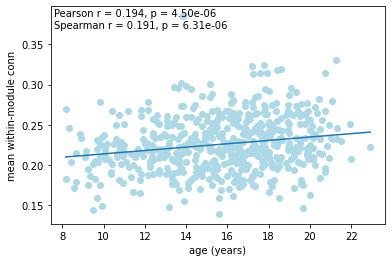

In [28]:
x = schaefer_df['ageAtScan']
y = schaefer_df['within']

fig, ax = plt.subplots()
plot_regress(x, y, ax=ax)
ax.set_ylabel('mean within-module conn')
plt.show()

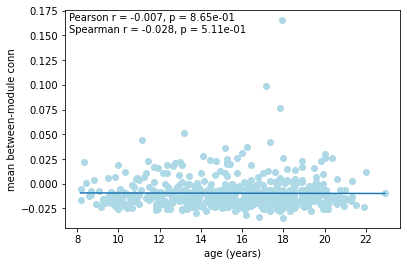

In [29]:
x = schaefer_df['ageAtScan']
y = schaefer_df['between']

fig, ax = plt.subplots()
plot_regress(x, y, ax=ax)
ax.set_ylabel('mean between-module conn')
plt.show()

In [59]:
outliers = schaefer_df.loc[schaefer_df['between'] > 0.08]

In [60]:
outliers.index

Int64Index([6224, 8921], dtype='int64')

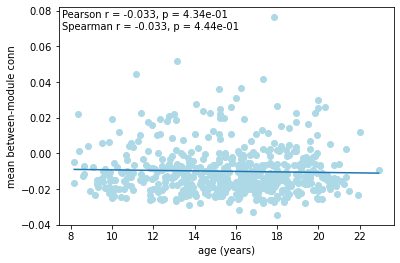

In [61]:
x = schaefer_df['ageAtScan'].drop(index=outliers.index)
y = schaefer_df['between'].drop(index=outliers.index)

fig, ax = plt.subplots()
plot_regress(x, y, ax=ax)
ax.set_ylabel('mean between-module conn')
plt.show()

In [39]:
## SAVE
schaefer_df.to_pickle('output/schaefer_df.pkl')

## Power264

In [46]:
ATLAS = 'power264'

### 10 modules
* Combine hand/mouth somatomotor
* Memory retrieval is speculative
* Ignore cerebellar and none

In [47]:
power264affiliation = np.loadtxt(
    ATLAS_PATH.format(atlas=ATLAS) + 'CommunityAffiliation.1D', dtype=int
) - 1  # 1 to 0 indexing
power264names = np.loadtxt(
    ATLAS_PATH.format(atlas=ATLAS) + 'CommunityNames.txt', dtype=str
).tolist()

In [48]:
power264names

['somatomotorHand',
 'somatomotorMouth',
 'cinguloopercular',
 'auditory',
 'default',
 'memoryRetrieval',
 'visual',
 'frontoparietal',
 'salience',
 'subcortical',
 'ventralAttention',
 'dorsalAttention',
 'cerebellar',
 'none']

In [49]:
module10names = ['somatomotor'] + power264names[2:5] + power264names[6:-2]

In [50]:
module10names

['somatomotor',
 'cinguloopercular',
 'auditory',
 'default',
 'visual',
 'frontoparietal',
 'salience',
 'subcortical',
 'ventralAttention',
 'dorsalAttention']

In [51]:
def module10(node):
    for i in range(10):
        if power264names[node].startswith(module10names[i]):
            return i
    return -1

In [52]:
module10affiliation = np.fromiter(map(module10, power264affiliation), dtype=int)

### mean within/between

In [53]:
power_loader = Atlas_Loader(ATLAS, module10affiliation)

In [54]:
power_df = age.loc[age.SUBJID.isin(power_loader.sub_files.keys())][['SUBJID', 'ageAtScan']]
power_df['ageAtScan'] = power_df['ageAtScan'] / 12

In [55]:
cache_dir = OUTPUT_PATH.format(atlas=ATLAS)
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

def sub_fcon_ccon(sub):
    fcon = power_loader.fcon_matrix(sub, fisher=True, cache=cache_dir)
    return power_loader.ccon_matrix(fcon)

from tqdm.contrib.concurrent import process_map
power_df['ccon'] = process_map(sub_fcon_ccon, power_df.SUBJID)

In [56]:
power_df['within'] = power_df['ccon'].apply(lambda ccon: ccon.diagonal().mean())
power_df['between'] = power_df['ccon'].apply(lambda ccon: ccon[np.triu_indices_from(ccon, k=1)].mean())

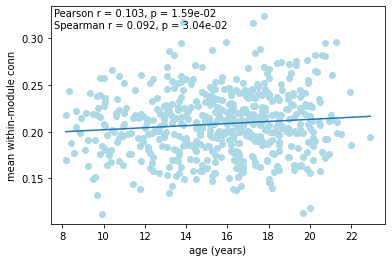

In [57]:
x = power_df['ageAtScan']
y = power_df['within']

fig, ax = plt.subplots()
plot_regress(x, y, ax=ax)
ax.set_ylabel('mean within-module conn')
plt.show()

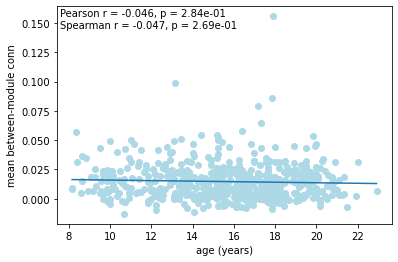

In [58]:
x = power_df['ageAtScan']
y = power_df['between']

fig, ax = plt.subplots()
plot_regress(x, y, ax=ax)
ax.set_ylabel('mean between-module conn')
plt.show()

In [62]:
outliers = power_df.loc[power_df['between'] > 0.08]

In [63]:
outliers.index

Int64Index([2532, 7048, 8921], dtype='int64')

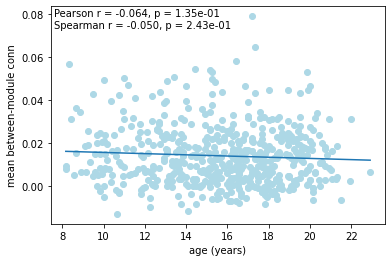

In [64]:
x = power_df['ageAtScan'].drop(index=outliers.index)
y = power_df['between'].drop(index=outliers.index)

fig, ax = plt.subplots()
plot_regress(x, y, ax=ax)
ax.set_ylabel('mean between-module conn')
plt.show()

In [65]:
## SAVE
power_df.to_pickle('output/power_df.pkl')

## Individual Modules

In [66]:
for m in range(power_loader.n_comm):
    power_df['within-' + str(m)] = power_df['ccon'].apply(lambda ccon: ccon[m][m])

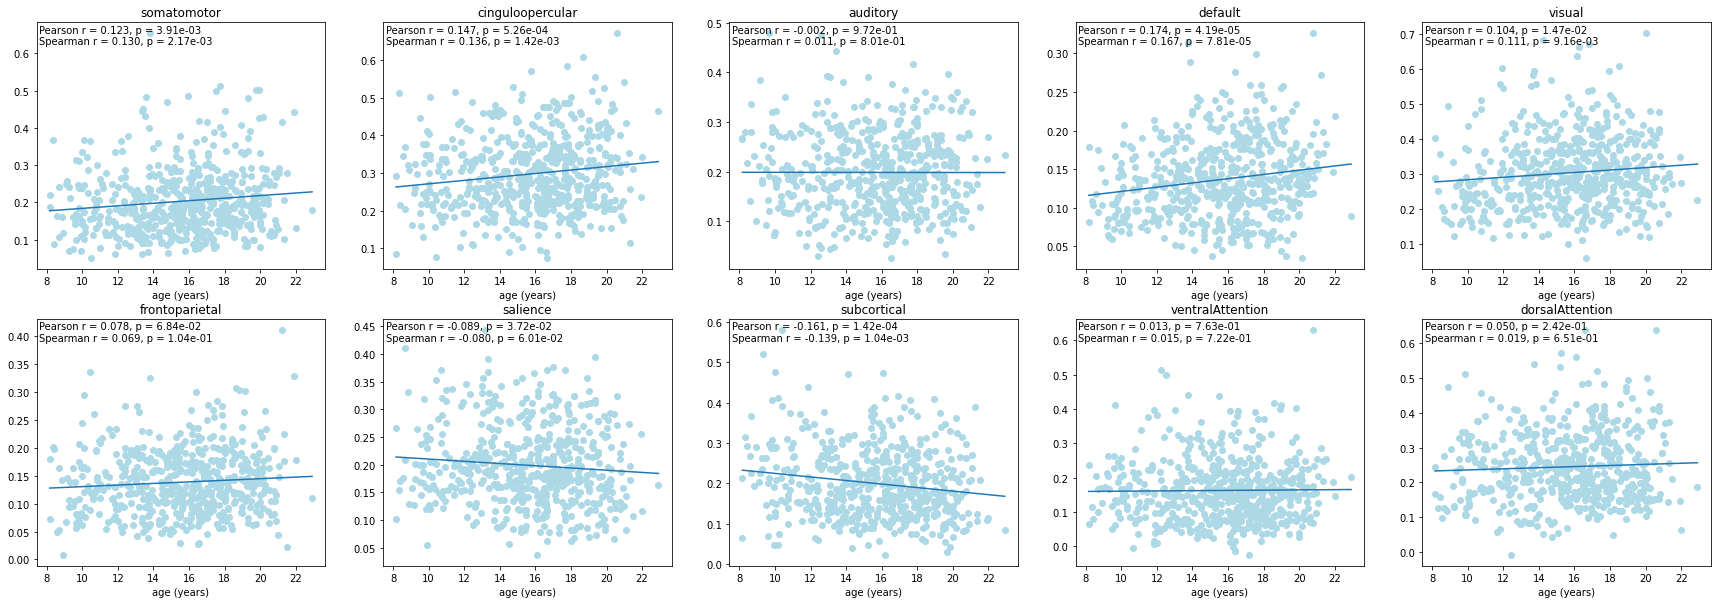

In [67]:
fix, axes = plt.subplots(2, 5, figsize=(30,10))

for c in range(power_loader.n_comm):
    i = c // 5
    j = c % 5
    plot_regress(power_df['ageAtScan'], power_df['within-' + str(c)], axes[i][j])
    axes[i][j].set_title(module10names[c])

plt.show()

In [68]:
for m in range(schaefer_loader.n_comm):
    schaefer_df['within-' + str(m)] = schaefer_df['ccon'].apply(lambda ccon: ccon[m][m])

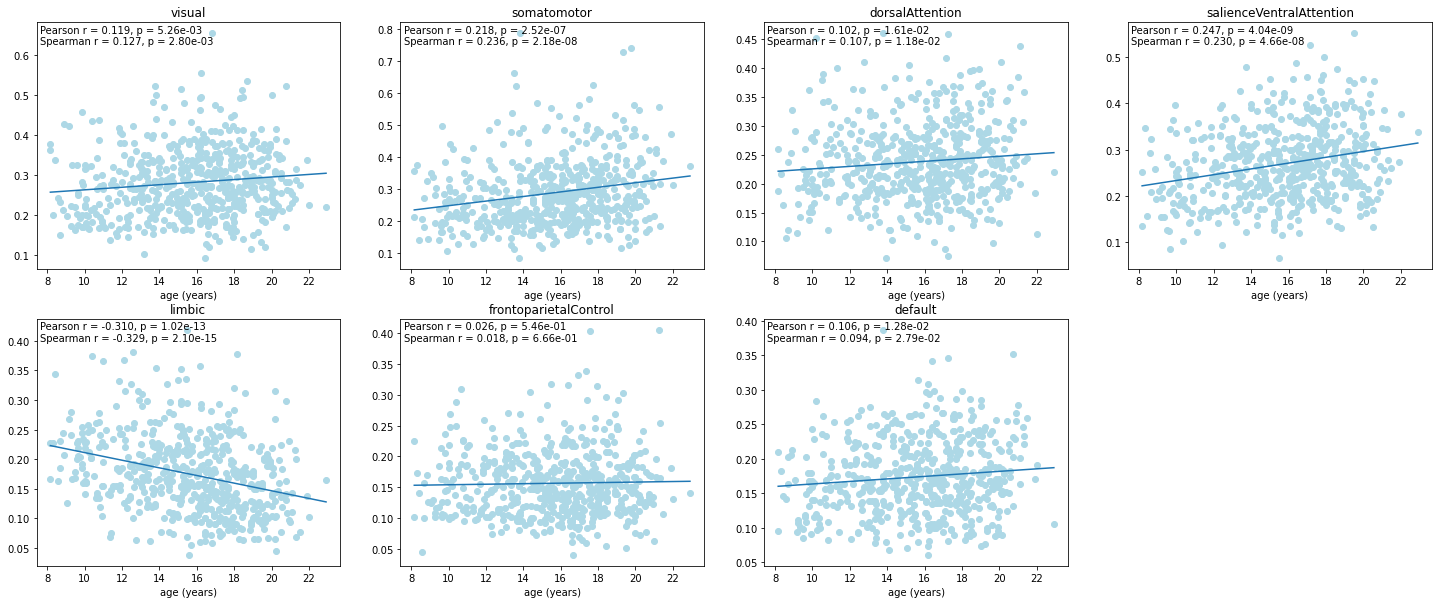

In [70]:
fix, axes = plt.subplots(2, 4, figsize=(25,10))

for c in range(schaefer_loader.n_comm):
    i = c // 4
    j = c % 4
    plot_regress(schaefer_df['ageAtScan'], schaefer_df['within-' + str(c)], axes[i][j])
    axes[i][j].set_title(schaefer_names[c])

axes[1, 3].set_visible(False)
plt.show()

# Graph Theory

In [4]:
fcon = np.load('output/fcon/schaefer400x7/sub-601098855033_fcon.npy')

In [7]:
fcon[~np.isnan(fcon)] = fcon[~np.isnan(fcon)] > np.nanquantile(fcon, 0.8)